[https://towardsdatascience.com/how-tracking-apps-analyse-your-gps-data-a-hands-on-tutorial-in-python-756d4db6715d](Link 1)

In [5]:
!pip install gpxpy
!pip install chart_studio
!pip install haversine

In [0]:
import gpxpy
import matplotlib.pyplot as plt
import datetime
from geopy import distance
from math import sqrt, floor
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
import haversine
import tqdm

# Loading data 

## Using GpxPy

In [15]:
gpx_file = open('/content/20191001-181138.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

print("Lenght of tracks: {}".format(len(gpx.tracks)))

print("Lenght of track segments: {}".format(len(gpx.tracks[0].segments)))

print("Number of points on a track segments: {}".format(len(gpx.tracks[0].segments[0].points)))

Lenght of tracks: 1
Lenght of track segments: 1
Number of points on a track segments: 3311


In [17]:
points = gpx.tracks[0].segments[0].points
print("Starting point: {}".format(points[0]))

print("Ending point: {}".format(points[-1]))

Starting point: [trkpt:27.72989188,85.32929305@1317.0@2019-10-01 12:26:38.019000+00:00]
Ending point: [trkpt:27.70685455,85.32227206@1254.0@2019-10-01 13:21:50+00:00]


## Using pandas

In [0]:
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])
for point in points:
    df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time}, ignore_index=True)

In [42]:
df.head()

,lon,lat,alt,time
0,85.329293,27.729892,1317.0,2019-10-01 12:26:38.019000+00:00
1,85.329489,27.729920,1314.0,2019-10-01 12:26:40.019000+00:00
2,85.329269,27.729928,1309.0,2019-10-01 12:26:41.019000+00:00
3,85.329177,27.729962,1281.0,2019-10-01 12:26:43.019000+00:00
4,85.329223,27.729983,1286.0,2019-10-01 12:26:44.019000+00:00


# Data viz

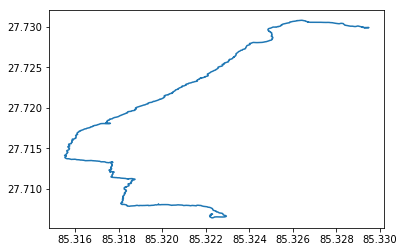

In [43]:
plt.plot(df['lon'], df['lat'])

In [47]:
time_dif = [0]
dist_dif_hav_2d = [0]

for index in range(len(points)):
    if index == 0:
        pass
    else:
        
        start = points[index-1]
        stop = points[index]
        time_delta = (stop.time - start.time).total_seconds()
        time_dif.append(time_delta)
        
        distance_hav_2d = haversine.haversine((start.latitude, start.longitude), (stop.latitude, stop.longitude))*1000
        dist_dif_hav_2d.append(distance_hav_2d)
        
print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')    

df['time_dif'] = time_dif
df['dis_dif_hav_2d'] = dist_dif_hav_2d

Total Time :  55  min  11  sec 


In [57]:
df['spd'] = (df['dis_dif_hav_2d'] / df['time_dif']) * 3.6
df =  df[df['spd'].notnull()]
df.describe()

,lon,lat,alt,time_dif,dis_dif_hav_2d,spd
count,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000
mean,85.320578,27.718258,1268.689426,1.000598,1.469674,5.274991
std,0.003537,0.007950,13.703270,0.024580,0.699410,2.260153
min,85.315520,27.706392,1239.000000,0.981000,0.018046,0.064967
25%,85.317704,27.711236,1260.000000,1.000000,1.169440,4.209985
50%,85.319831,27.718038,1267.000000,1.000000,1.427619,5.139430
75%,85.322922,27.725542,1280.000000,1.000000,1.724969,6.209887
max,85.329489,27.730829,1314.000000,2.000000,21.637953,77.896632


In [58]:
avg_km_h = (sum((df['spd'] * df['time_dif'])) / sum(df['time_dif']))

avg_km_h

5.287662250177833

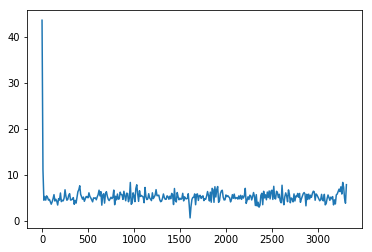

In [59]:
df['time10s'] = list(map(lambda x: round(x, -1)
                         , np.cumsum(df['time_dif'])))

plt.plot(df.groupby(['time10s']).mean()['spd'])